# Employee turnover project

## Reading and checking the dataset

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay, classification_report



In [2]:
# Please note that column number 9 had the header 'sales'. I have changed it to 'dept' in the excel file for better readability
df = pd.read_excel('1688640705_hr_comma_sep.xlsx')

In [3]:
df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,dept,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   dept                   14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


<span style="color:orange">
There are a total of 14999 rows in the dataset and there are no nulls in any column. No further treatment on data required
</span>

## Exploratory data analysis (EDA)

In [5]:
df.describe()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.238083,0.021268
std,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.425924,0.144281
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


<span style="color:orange">
&#x2022; The employee turnover in the given dataset is 23.8 % (mean value of `left` column) <br>
&#x2022; We use groupby for EDA wrt categorical features and histogram for numerical features
<span>

In [6]:
df.groupby('dept')[['left']].aggregate(['count','sum', 'mean']).sort_values(('left', 'mean'),ascending=False)

left                
            count   sum      mean
dept                             
hr            739   215  0.290934
accounting    767   204  0.265971
technical    2720   697  0.256250
support      2229   555  0.248991
sales        4140  1014  0.244928
marketing     858   203  0.236597
IT           1227   273  0.222494
product_mng   902   198  0.219512
RandD         787   121  0.153748
management    630    91  0.144444

<span style="color:orange">
Some departments have a higher turneover as compared to company average:<br><br>
&#x2022; Departments with dept turnover > company turnover: hr, accounting, technical, support, sales<br>
&#x2022; Departments with dept turnover < company turnover: marketing, IT, product_mng, RandD, management<br>
<span>

In [7]:
df.groupby('salary')[['left']].aggregate(['count','sum', 'mean']).sort_values(('left', 'mean'),ascending=False)

left                
       count   sum      mean
salary                      
low     7316  2172  0.296884
medium  6446  1317  0.204313
high    1237    82  0.066289

<span style="color:orange">
Salary is clearly affecting the employee turnover. It is much higher in low and medium salary employees as compared to those with high salary.
<span>

<Axes: >

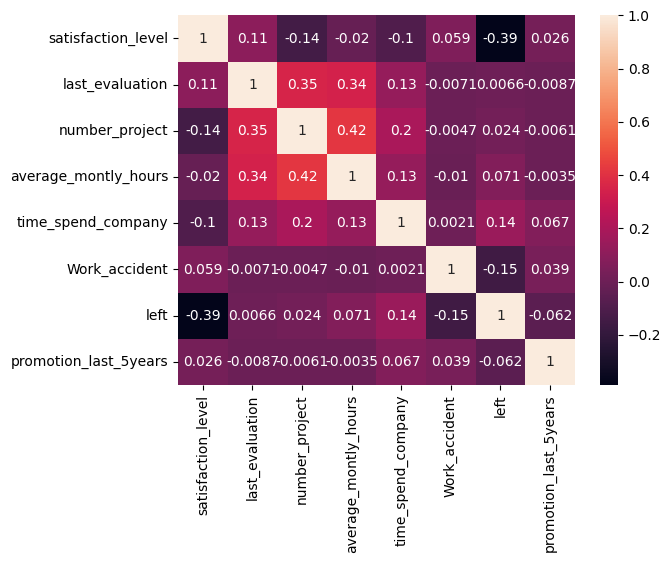

In [8]:
sns.heatmap(df.corr(numeric_only=True),annot=True)

<span style="color:orange">
We can see the features number_project, average_monthly_hours and last_evaluation have a considerable correlation between each other. This may impact the machine learning model performance.
</span>

In [9]:
df.columns

Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company', 'Work_accident', 'left',
       'promotion_last_5years', 'dept', 'salary'],
      dtype='object')

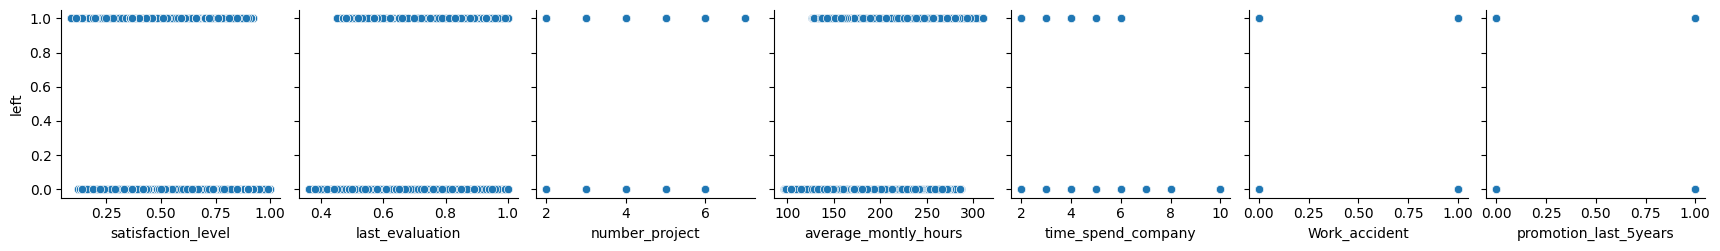

In [10]:
pp = sns.pairplot(data=df,
                  y_vars=['left'],
                  x_vars=['satisfaction_level', 'last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company', 'Work_accident',
       'promotion_last_5years'])

<Axes: xlabel='promotion_last_5years', ylabel='Count'>

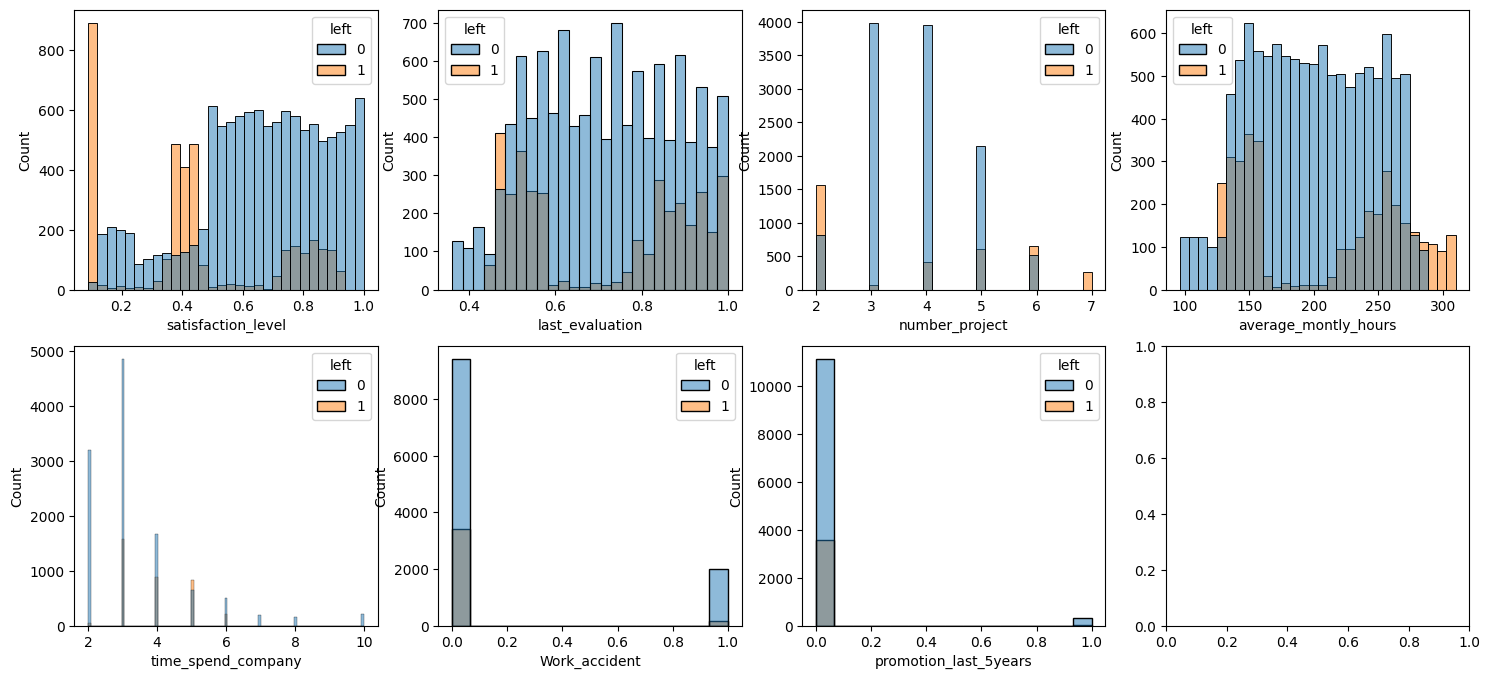

In [11]:
figure, axes = plt.subplots(2, 4, figsize=(18,8))
sns.histplot(df, x='satisfaction_level', hue='left',ax=axes[0,0])
sns.histplot(df, x='last_evaluation', hue='left',ax=axes[0,1])
sns.histplot(df, x='number_project', hue='left',ax=axes[0,2])
sns.histplot(df, x='average_montly_hours', hue='left',ax=axes[0,3])
sns.histplot(df, x='time_spend_company', hue='left',ax=axes[1,0])
sns.histplot(df, x='Work_accident', hue='left',ax=axes[1,1])
sns.histplot(df, x='promotion_last_5years', hue='left',ax=axes[1,2])

<span style="color:orange">
Plotting the histograms based on different parameters provide an insight on what could affect employee turnover. Following observations can be made:<br><br>
&#x2022; Employees with lower satisfaction have a higher chance of leaving the company<br>
&#x2022; Employees on the lower end and the upper end of the evaluation score are at higher risk of leaving as compared to employees with average rated employees<br>
&#x2022; Chances of employees leaving the company is higher if the number of projects are lowest and highest<br>
&#x2022; Employees with average monthly hours in the range 150 - 200 hours are less likely to leave the company<br>
&#x2022; People who have spent 3-4 years in the company are more likely to leave the company as compared with people spending <= 2 years abd >= 4 years<br>
&#x2022; People without promotions are more inclined to leave the company
<span>

## Clustering

In [12]:
df_clust = df[df['left']==1][['satisfaction_level','last_evaluation']].reset_index(drop=True)

KM = KMeans(n_clusters=3, random_state=30)
df_clust['cluster'] = KM.fit_predict(df_clust[['satisfaction_level', 'last_evaluation']])
df_clust

,satisfaction_level,last_evaluation,cluster
0,0.38,0.53,0
1,0.80,0.86,1
2,0.11,0.88,2
3,0.72,0.87,1
4,0.37,0.52,0
...,...,...,...
3566,0.40,0.57,0
3567,0.37,0.48,0
3568,0.37,0.53,0
3569,0.11,0.96,2


Text(0, 0.5, 'last_evaluation')

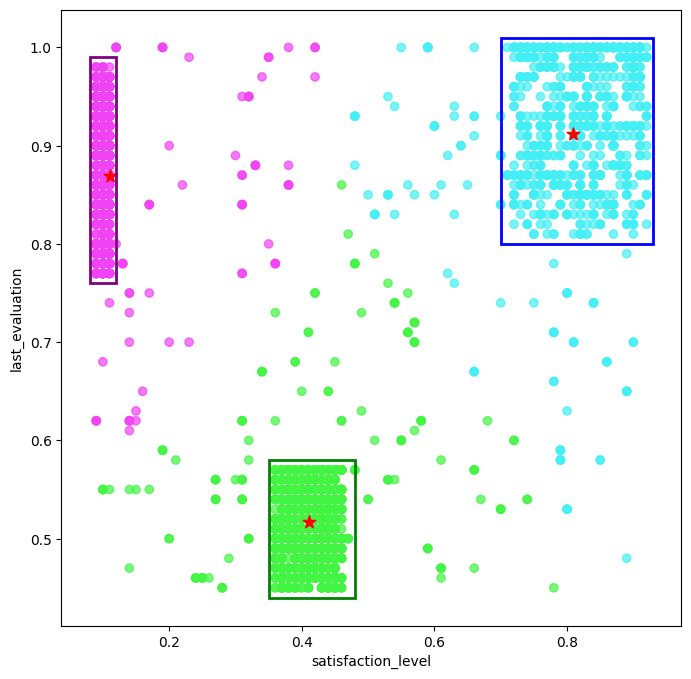

In [13]:
# define the centroids -we expect 3 centroids
centroids = KM.cluster_centers_

cent_x = [i[0] for i in centroids] # gives every result in the x coordinates
cent_y = [i[1] for i in centroids]

df_clust['cent_x'] = df_clust['cluster'].map({#mapping centroids to their clusters based on index positions
                                    0:cent_x[0], 
                                    1:cent_x[1],
                                    2:cent_x[2]
                                })

df_clust['cent_y'] = df_clust['cluster'].map({#mapping centroids to their clusters based on index positions
                                    0:cent_y[0], 
                                    1:cent_y[1],
                                    2:cent_y[2]
                                })

my_cust_col = ['#42f542','#42eff5', '#f242f5'] # Green, Blue, Pink

df_clust['clust_col'] = df_clust['cluster'].map({#mapping colors
                                    0:my_cust_col[0], 
                                    1:my_cust_col[1],
                                    2:my_cust_col[2]
                                })

#with centroids
# plt.style.use('dark_background')
plt.figure(figsize=(8,8))
plt.scatter(df_clust['satisfaction_level'], df_clust['last_evaluation'], c=df_clust['clust_col'], alpha = 0.7)
plt.scatter(cent_x, cent_y, marker='*', s=90, c='red')
shape1 = plt.Rectangle((0.35,0.44), 0.13, 0.14,ec='green',fc='none', lw=2)
plt.gca().add_patch(shape1)
shape2 = plt.Rectangle((0.7,0.8), 0.23, 0.21,ec='blue',fc='none', lw=2)
plt.gca().add_patch(shape2)
shape3 = plt.Rectangle((0.08,0.76), 0.04, 0.23,ec='purple',fc='none', lw=2)
plt.gca().add_patch(shape3)
plt.xlabel('satisfaction_level')
plt.ylabel('last_evaluation')

In [14]:
clust_info=pd.DataFrame(df_clust['cluster'].value_counts())
clust_info['Color']=['Green','Blue','Pink']
clust_info

,count,Color
cluster,,
0,1650,Green
1,977,Blue
2,944,Pink


<span style="color:orange">
From the graph, it is unclear as to which cluster is the largest. However, when we see the value counts , it is clear that most people belong to cluster 0 and count of cluster 1 and cluster 2 are identical. Following observations can be made about the clusters: <br><br>

&#x2022; Within each cluster, most of the points are aggregated in small region indicated by the rectangles inside the plot. <br>
&#x2022; Cluster 0: These are the employees with low last_evaluation score (compared to company average of 0.71) and low to medium satisfaction level <br>
&#x2022; Cluster 1: These employees have a high satisfaction score and high performance. <br>
&#x2022; Cluster 2: These employees have a low satisfaction score and high performance (comparable to cluster 0). <br><br>

My interpretation of the clusters: <br><br>
&#x2022; Cluster 0 employees may leave the company due to high performance pressure and satisfaction level is not that great.<br>
&#x2022; Cluster 2 employees may also leave the company due to low satisfaction levels and they have better chances of finding opporunities outside because of their higher performance<br>
&#x2022; Employees in cluster 1 is a curious case because one would expect people to stay on if satisfaction and performance levels are good. We need to take a look at additional data like number of promotions and projects to understand this cluster better <br>

</span>

In [15]:
df['left'].value_counts()

left
0    11428
1     3571
Name: count, dtype: int64

<span style="color:orange">
As expected, the number of samples corresponding to left=0 > left=1 (as stayers > quitters from common experience)
</span>

In [16]:
df = pd.get_dummies(df, columns=['dept', 'salary'], dtype=int)

In [17]:
print(df.columns)
df.head()

Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company', 'Work_accident', 'left',
       'promotion_last_5years', 'dept_IT', 'dept_RandD', 'dept_accounting',
       'dept_hr', 'dept_management', 'dept_marketing', 'dept_product_mng',
       'dept_sales', 'dept_support', 'dept_technical', 'salary_high',
       'salary_low', 'salary_medium'],
      dtype='object')


,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,dept_IT,dept_RandD,...,dept_hr,dept_management,dept_marketing,dept_product_mng,dept_sales,dept_support,dept_technical,salary_high,salary_low,salary_medium
0,0.38,0.53,2,157,3,0,1,0,0,0,...,0,0,0,0,1,0,0,0,1,0
1,0.80,0.86,5,262,6,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,1
2,0.11,0.88,7,272,4,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,1
3,0.72,0.87,5,223,5,0,1,0,0,0,...,0,0,0,0,1,0,0,0,1,0
4,0.37,0.52,2,159,3,0,1,0,0,0,...,0,0,0,0,1,0,0,0,1,0


In [18]:
# First we separate the target from the features

X = df.drop('left', axis=1)
y = df['left']

X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(X, y
                                                    , test_size=0.2
                                                    , random_state=123
                                                    , stratify=y
                                                    )

# These prints show that the same imbalance is maintained in the test and train dataset

print("Checking the value counts and ratio before applying SMOTE\n\n")

print(y_train_orig.value_counts(normalize=False))
print(y_test_orig.value_counts(normalize=False))

print('')

print("Checking the value counts after applying SMOTE\n\n")

SM = SMOTE()
X_train, y_train = SM.fit_resample(X_train_orig,y_train_orig)
X_test, y_test = SM.fit_resample(X_test_orig,y_test_orig)

print(y_train.value_counts(normalize=False))
print(y_test.value_counts(normalize=False))

Checking the value counts and ratio before applying SMOTE


left
0    9142
1    2857
Name: count, dtype: int64
left
0    2286
1     714
Name: count, dtype: int64

Checking the value counts after applying SMOTE


left
0    9142
1    9142
Name: count, dtype: int64
left
0    2286
1    2286
Name: count, dtype: int64


## Training with Logistic Regression model

In [19]:
logModel = LogisticRegression()

In [20]:
param_grid_lr = [    
    {'penalty' : [ 'l2', None],
    'C' : np.logspace(-3, 3, 7),
    # 'solver' : ['lbfgs','newton-cg','liblinear','sag','saga'],
    'max_iter' : [100, 1000, 5000]
    }
]

In [21]:
GS_logModel = GridSearchCV(logModel, param_grid = param_grid_lr, cv = 5, verbose=True, n_jobs=-1, scoring='accuracy')

In [22]:
GS_logModel.fit(X_train, y_train)

Fitting 5 folds for each of 42 candidates, totalling 210 fits


GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid=[{'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                          'max_iter': [100, 1000, 5000],
                          'penalty': ['l2', None]}],
             scoring='accuracy', verbose=True)

Best accuracy score on training data: 0.81
Accuracy score on test data for best model: 0.84
              precision    recall  f1-score   support

           0       0.87      0.79      0.83      2286
           1       0.81      0.89      0.85      2286

    accuracy                           0.84      4572
   macro avg       0.84      0.84      0.84      4572
weighted avg       0.84      0.84      0.84      4572



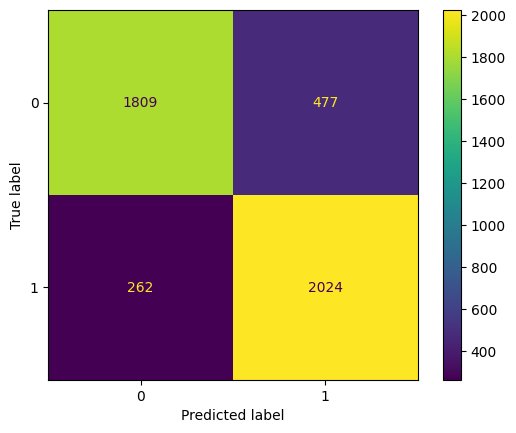

In [23]:
logModel_best = GS_logModel.best_estimator_
print(f'Best accuracy score on training data: {GS_logModel.best_score_:.2f}')

y_test_hat = logModel_best.predict(X_test)
acc_test_logModel = accuracy_score(y_test, y_test_hat)

print(f'Accuracy score on test data for best model: {acc_test_logModel:.2f}')

print(classification_report(y_test, y_test_hat))
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test,y_test_hat))
disp.plot()

## Training with Random Forest model

In [24]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 80, num = 10)]
# Maximum number of levels in tree
max_depth = [2,4]
# Minimum number of samples required to split a node
min_samples_split = [2, 5]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the param grid
param_grid_rf = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [25]:
rf_Model = RandomForestClassifier()
rf_Grid = GridSearchCV(estimator = rf_Model, param_grid = param_grid_rf, cv = 5, verbose=True, n_jobs = -1, scoring='accuracy')

In [26]:
rf_Grid.fit(X_train, y_train)

Fitting 5 folds for each of 160 candidates, totalling 800 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True, False], 'max_depth': [2, 4],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [10, 17, 25, 33, 41, 48, 56, 64, 72,
                                          80]},
             scoring='accuracy', verbose=True)

Best accuracy score on training data: 0.95
Accuracy score on test data for best model: 0.94
              precision    recall  f1-score   support

           0       0.93      0.95      0.94      2286
           1       0.95      0.93      0.94      2286

    accuracy                           0.94      4572
   macro avg       0.94      0.94      0.94      4572
weighted avg       0.94      0.94      0.94      4572



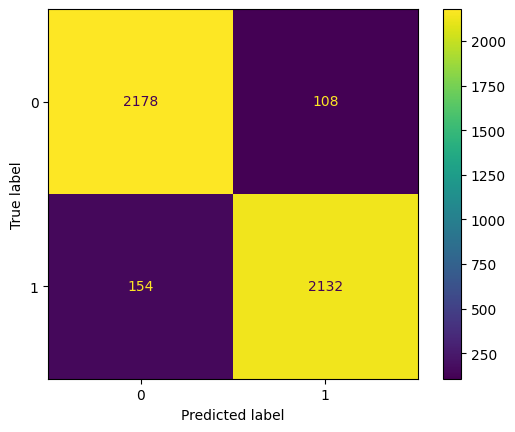

In [27]:
rfModel_best = rf_Grid.best_estimator_
print(f'Best accuracy score on training data: {rf_Grid.best_score_:.2f}')

y_test_hat = rfModel_best.predict(X_test)
acc_test_rfModel = accuracy_score(y_test, y_test_hat)

print(f'Accuracy score on test data for best model: {acc_test_rfModel:.2f}')
print(classification_report(y_test, y_test_hat))
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test,y_test_hat))
disp.plot()

## Training with gradient boosting classifier

In [28]:
param_grid_gb = [    
    {'learning_rate' : [ 0.001, 0.01,0.1],
     'subsample' : [0.2, 0.5, 0.9],
    #  'n_estimators' : [100, 500, 1000],
    'max_depth' : [4, 6, 8]
    }
]

In [29]:
gbModel = GradientBoostingClassifier()
gbGrid = GridSearchCV(estimator = gbModel, param_grid = param_grid_gb, cv = 5, verbose=True, n_jobs = -1, scoring='accuracy')

In [30]:
gbGrid.fit(X_train,y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


GridSearchCV(cv=5, estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid=[{'learning_rate': [0.001, 0.01, 0.1],
                          'max_depth': [4, 6, 8],
                          'subsample': [0.2, 0.5, 0.9]}],
             scoring='accuracy', verbose=True)

Best accuracy score on training data: 0.98
Accuracy score on test data for best model: 0.98
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      2286
           1       0.99      0.97      0.98      2286

    accuracy                           0.98      4572
   macro avg       0.98      0.98      0.98      4572
weighted avg       0.98      0.98      0.98      4572



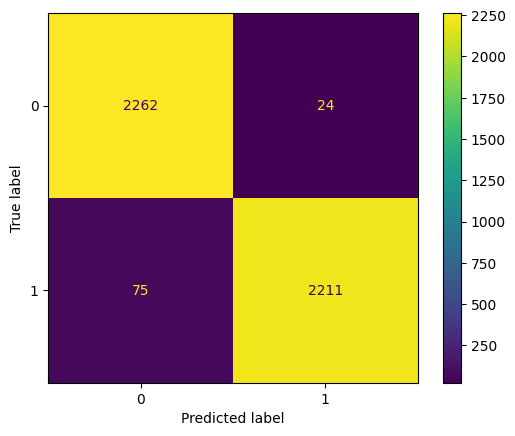

In [31]:
gbModel_best = gbGrid.best_estimator_
print(f'Best accuracy score on training data: {gbGrid.best_score_:.2f}')

y_test_hat = gbModel_best.predict(X_test)
acc_test_gbModel = accuracy_score(y_test, y_test_hat)

print(f'Accuracy score on test data for best model: {acc_test_gbModel:.2f}')
print(classification_report(y_test, y_test_hat))
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test,y_test_hat))
disp.plot()

## Model selection by plottting ROC and finding AUC

In [32]:
y_pred_prob_LR = logModel_best.predict_proba(X_test)
y_pred_prob_positive_LR = y_pred_prob_LR[:,1]

# calculate false positive rate (fpr) and true positive rate(tpr)
fpr_LR, tpr_LR, thresholds_LR = roc_curve(y_test, y_pred_prob_positive_LR)
roc_auc_LR = auc(fpr_LR, tpr_LR)

In [33]:
y_pred_prob_RF = rfModel_best.predict_proba(X_test)
y_pred_prob_positive_RF = y_pred_prob_RF[:,1]

# calculate false positive rate (fpr) and true positive rate(tpr)
fpr_RF, tpr_RF, thresholds_RF = roc_curve(y_test, y_pred_prob_positive_RF)
roc_auc_RF = auc(fpr_RF, tpr_RF)

In [34]:
y_pred_prob_GB = gbModel_best.predict_proba(X_test)
y_pred_prob_positive_GB = y_pred_prob_GB[:,1]

# calculate false positive rate (fpr) and true positive rate(tpr)
fpr_GB, tpr_GB, thresholds_GB = roc_curve(y_test, y_pred_prob_positive_GB)
roc_auc_GB = auc(fpr_GB, tpr_GB)

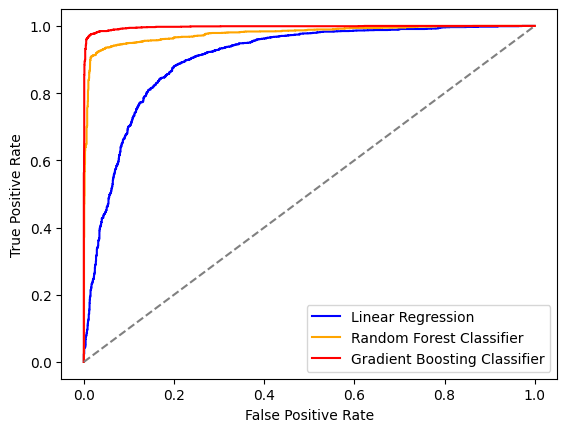

In [35]:
import matplotlib.pyplot as plt
plt.plot(fpr_LR,tpr_LR, c='blue')
plt.plot(fpr_RF,tpr_RF, c='orange')
plt.plot(fpr_GB,tpr_GB, c='red')


plt.plot([0,1],[0,1], linestyle='--', c='grey')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(['Linear Regression','Random Forest Classifier','Gradient Boosting Classifier'])

In [36]:
# AUC comparison

df_AUC=pd.DataFrame(
    {
        'Model':['Linear Regression','Random Forest Classifier','Gradient Boosting Classifier'],
        'AUC': [roc_auc_LR, roc_auc_RF, roc_auc_GB]
    }
)
df_AUC

,Model,AUC
0,Linear Regression,0.902158
1,Random Forest Classifier,0.977725
2,Gradient Boosting Classifier,0.996966


<span style="color:orange">

 Gradient Boosting (GB) Classifier is the best as compared to Logistic Regression and Random Forest classifiers:  <br><br>

&#x2022; As seen from the ROC curve, the GB model has the highest AUC and almost idealistic inverted L shape <br>
&#x2022; As seen from the classification report, the precision and recall are much higher <br><br>

Recall/Precicison: Which is important?<br>

&#x2022; We are okay with false positives but not okay with false negatives. False negatives means we fail to pay attention to employees who are at the risk of leaving company leading to higher turnover.

</span>

## Categorization of Employees

In [48]:
# Since we use SMOTE to address data imbalance, there are synthetic datapoints in the dataset used by the ML model

cat_table=pd.DataFrame(gbModel_best.predict_proba(X)[:,1],columns=['Probability'])
bins=[0,0.2,0.6,0.9,1]
labels=['Safe','Low risk','Medium risk','High risk']
cat_table['Category']=pd.cut(cat_table['Probability'],bins,labels=labels)
cat_table_summary = cat_table.groupby('Category').count().reset_index()
cat_table_summary.columns = ['Category','Count']
cat_table_summary
# cat_table.head()

C:\Users\Admin\AppData\Local\Temp\ipykernel_27544\1516136766.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cat_table_summary = cat_table.groupby('Category').count().reset_index()


,Category,Count
0,Safe,11318
1,Low risk,143
2,Medium risk,143
3,High risk,3395


<span style="color:orange">
  The company needs to pay attention to Low risk and Medium risk employees as they can be pursuaded to stay by taking the right measures. <br>
  In the high risk category, probability is >90% for leaving and hence very difficult to get them to stay. Only members really important to the company can be targeted
  and close individual attention should be given to these employees in order to retain them.
</span>